<a href="https://colab.research.google.com/github/binliu0630/Deep_Learning/blob/master/Fastai%2BTransformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get Started

In [3]:
!pip install transformers

     |████████████████████████████████| 368kB 4.9MB/s 
     |████████████████████████████████| 1.0MB 53.3MB/s 
     |████████████████████████████████| 860kB 56.4MB/s 
     |████████████████████████████████| 645kB 64.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=29a46ab499cda9b38b57d56693bfd78572f7864403d2a16f6e93745da36fca03
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses


In [4]:
import fastai
import transformers
print(f'fastai version: {fastai.__version__}')
print(f'transformers version: {transformers. __version__}')

fastai version: 1.0.59
transformers version: 2.2.1


In [0]:
import numpy as np
import pandas as pd
from pathlib import Path

import os

import torch
import torch.optim as optim

import random

# fastai
from fastai import *
from fastai.text import *
from fastai.callback import *

# transformer
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig 

In [6]:
torch.cuda.is_available()

True

## Loading the Data

In [0]:
data_path = "https://s3.amazonaws.com/tomk/h2o-world/megan/AmazonReviews.csv"
data = pd.read_csv(data_path)

In [8]:
data.head(2)

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...
1,B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1323907200,"Everything is ok, except it just isn't as good..."


In [0]:
# create the binary label
data['label'] = np.where(data['Score'] > 3, '1', '0')

# change score into categorical so it can be the multiclass label
data['Score'] = data['Score'].astype('category')


In [10]:
data.sample()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,label
1052,B004G5ZYN8,A14Q0HNK3UOO6O,My Puggle Pup Loves It!,5,1,96068,WilDip,1,1317340800,My puggle pup is only 6 months old and he love...,1


In [0]:
# split the data by timestamp
timesplit = data['Time'].quantile(0.8)

In [12]:
train = data[data['Time'] < timesplit]
test = data[data['Time'] >= timesplit]
train.shape, test.shape

((79992, 11), (20008, 11))

## FASTAI + TRANSFORMER

In [0]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

In [0]:
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-base'

# model_type = 'bert'
# pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased-distilled-squad'#'distilbert-base-uncased'#'distilbert-base-uncased'

# model_type = 'xlm'
# pretrained_model_name = 'xlm-clm-enfr-1024'

#model_type = 'xlnet'
#pretrained_model_name = 'xlnet-base-cased'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [47]:
# all the pretrained model for the specific model_class
model_class.pretrained_model_archive_map

{'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-pytorch_model.bin',
 'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-pytorch_model.bin',
 'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-openai-detector-pytorch_model.bin',
 'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-pytorch_model.bin',
 'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-pytorch_model.bin',
 'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-openai-detector-pytorch_model.bin'}

In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(seed)

### 1 Setup FASTAI Databunch

In [49]:
# load the pretrained tokenizer
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)

100%|██████████| 456318/456318 [00:00<00:00, 1444467.23B/s]


In [50]:
transformer_tokenizer.max_len

512

###### Create Custom FASTAI TOKENIER from pretrained transformer tokenizer

In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
        return [CLS] + tokens + [SEP]

In [0]:
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [53]:
tokenizer_class.pretrained_vocab_files_map

{'merges_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-merges.txt',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt',
  'roberta-large': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt',
  'roberta-large-mnli': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-mnli-merges.txt',
  'roberta-large-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-large-merges.txt'},
 'vocab_file': {'distilroberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/distilroberta-base-vocab.json',
  'roberta-base': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'roberta-base-openai-detector': 'https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json',
  'robert

###### Create Custom FASTAI Vocab from the pretrained transformer tokenizer

In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

In [0]:
fastai_vocab = TransformersVocab(tokenizer=transformer_tokenizer)

###### Create Custom FASTAI Processor

In [0]:
numericalize_processor = NumericalizeProcessor(vocab=fastai_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)


In [0]:
fastai_processor = [tokenize_processor, numericalize_processor]

###### Create Custom FASTAI Databunch

In [58]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)

[CLS] token : <s>
[SEP] token : </s>
[PAD] token : <pad>


In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [60]:
databunch = (TextList.from_df(train, cols='Text', processor=fastai_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'label')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [61]:
databunch.show_batch(10)

text,target
"<s> ĠThis Ġproduct Ġis Ġsimply Ġfabulous . Ġ ĠI Ġpurchased Ġit Ġfor Ġmy Ġ7 Ġmonth Ġold Ġpit Ġbull , Ġwho Ġis Ġalways Ġinto Ġsomething Ġand Ġvery Ġhighly Ġfood Ġmotivated . Ġ ĠPrior Ġto Ġthe Ġeverlasting Ġtreat Ġball Ġher Ġfavorite Ġtoy Ġwas Ġthe ĠChuck le , Ġmade Ġby ĠPremier . Ġ ĠThe Ġadvantage Ġto Ġthe Ġchuckle Ġis Ġthat ĠI Ġcould Ġfill Ġit Ġwith Ġher Ġfood Ġfor Ġa Ġnutritious Ġbut Ġfun Ġtoy",1
"<s> ĠI Ġbought Ġthis Ġproduct Ġaround Ġthe Ġbeginning Ġto Ġmiddle Ġof ĠMay Ġ2011 Ġ& , Ġat Ġthat Ġtime , Ġit Ġshowed Ġa Ġpicture Ġof Ġthe Ġbox Ġfrom Ġthe Ġcompany ĠCult ures Ġfor ĠHealth ĠLLC . Ġ ĠIt Ġalso Ġhad Ġ(& Ġstill Ġhas ) Ġtheir Ġname Ġon Ġit Ġas Ġ"" by ĠCult ures Ġof ĠHealth ĠLLC "" Ġbut Ġthen Ġfurther Ġdown Ġis Ġsays Ġ"" S hips Ġfrom Ġand Ġsold Ġby ĠLifetime",1
"<s> ĠI Ġhave Ġbeen Ġon Ġsomething Ġof Ġhoney Ġj ag Ġthis Ġyear . Ġ ĠIt Ġseems Ġto Ġfind Ġit 's Ġway Ġinto Ġeverything Ġaround Ġme Ġfrom Ġbaked Ġgoods Ġto Ġbath Ġproducts . Ġ ĠHoney Ġis Ġbetter Ġfor Ġyou Ġthan Ġthe Ġvast Ġmajority Ġwhat Ġit Ġthere . Ġ Ġ( I Ġdiscovered , Ġjust Ġa Ġday Ġor Ġ2 Ġago , Ġwhen Ġper using Ġ< a Ġhref ="" http :// www . amazon",1
"<s> ĠI Ġbelieve Ġthat Ġpeople Ġneed Ġto Ġbe Ġaware Ġof Ġthe Ġfact Ġthat Ġthe Ġk ibble Ġsize Ġof Ġthe ĠAdult ĠOral ĠCare ĠDry ĠCat ĠFood Ġis ĠVERY Ġlarge Ġand Ġpresents Ġa Ġpotential Ġchoking Ġhazard Ġto Ġtheir Ġpets . Ġ ĠI Ġtransitioned Ġmy Ġcat Ġto Ġthis Ġfood Ġfrom Ġthe ĠScience ĠDiet Ġkitten Ġformula Ġwhen Ġhe Ġwas Ġabout Ġ15 Ġmonths Ġold . Ġ ĠFrom Ġday Ġone , ĠI Ġthought Ġthat Ġthe Ġk",0
"<s> ĠI Ġdecided Ġto Ġswitch Ġfrom Ġgrocery Ġstore Ġmilk Ġto ĠS AC O 's Ġpowder Ġfor Ġmathematical Ġreasons . ĠAs Ġa Ġsingle Ġlady Ġwho Ġuses Ġmilk Ġprimarily Ġfor Ġmy Ġtea , ĠI Ġrarely Ġfinish Ġa Ġone - gall on Ġbottle Ġbefore Ġit Ġs ours Ġ( hate Ġthat Ġrace Ġto Ġuse Ġit Ġall !), Ġand Ġbuying Ġhalf Ġgallon Ġcontainers Ġabsolutely Ġbugs Ġme , Ġas Ġit Ġcosts Ġfive Ġbucks Ġfor Ġtwo Ġ(",1
"<s> ĠI Ġhave Ġmany Ġreviews Ġfor ĠBarry ĠFarm Ġproducts Ġhere Ġon ĠAmazon . Ġ ĠMaybe Ġa Ġdozen Ġor Ġso . Ġ ĠIf Ġthey Ġare Ġnot Ġthe Ġlargest Ġdistributor Ġof Ġdried Ġveggies , Ġspices , Ġherbs , Ġetc , Ġthan Ġthey Ġhave Ġto Ġbe Ġvery Ġclose . Ġ ĠI Ġbecame Ġfamiliar Ġwith ĠBarry ĠFarm Ġproducts Ġmany Ġyears Ġago Ġwhen ĠI Ġfirst Ġstarted Ġdoing Ġa Ġlot Ġof Ġhiking . Ġ ĠTheir Ġfresh",1
"<s> Ġ< span Ġclass ="" tiny ""> ĠLength :: Ġ4 : 17 ĠM ins < br Ġ/ >< br Ġ/> </ span > I Ġtalk Ġin Ġthe Ġvideo Ġabout Ġhow Ġit Ġis Ġconfusing Ġwhen Ġthe Ġproduct Ġsent Ġis Ġsomewhat Ġdifferent Ġfrom Ġthe Ġproduct Ġthat Ġyou Ġsee Ġon Ġthe Ġweb .< br Ġ/ >< br Ġ/> I 'm Ġdisappointed Ġthat Ġthe Ġcalcium Ġcontent Ġlisted Ġon Ġthe Ġweb Ġwas Ġ30 % Ġbut",1
"<s> ĠI Ġdecided Ġto Ġre - write Ġmy Ġreview Ġin Ġorder Ġto Ġlet Ġyou Ġguys Ġin Ġon Ġhow Ġmy Ġcat 's Ġbeen Ġdoing Ġon Ġthe ĠWar u va Ġcat Ġfood .< br Ġ/ >< br Ġ/> We Ġdecided Ġto Ġtry Ġpretty Ġmuch Ġevery Ġflavor Ġon Ġhere Ġbecause ĠI Ġcouldn 't Ġfind Ġany Ġreally Ġgood Ġspecific Ġreviews Ġfor Ġanything Ġother Ġthan Ġone Ġor Ġtwo Ġflavors , Ġhere 's Ġhow Ġmy Ġcats",1
"<s> ĠGo Ġto Ġ[ ... ]. Ġ ĠSearch Ġfor Ġthe Ġvideo Ġentitled : Ġ ĠWHO LE ĠFO OD S ĠMARK ET Ġ"" OR GAN IC "" ĠFO OD ĠM ADE ĠIN ĠCH INA !!!! < br Ġ/ >< br Ġ/> According Ġto Ġmy Ġresearch , ĠChina Ġis Ġthe Ġmajor Ġsupplier Ġof ĠGo ji Ġberries . Ġ ĠThere 's Ġbeen Ġan Ġunresolved Ġgrowing Ġconcern Ġabout Ġfood , Ġany Ġfood Ġproduced Ġin",0
"<s> ĠI Ġrealize ĠI Ġam Ġjust Ġadding Ġmy Ġvoice Ġto Ġthe Ġchorus Ġof Ġapproval Ġabout ĠT ilda ĠBas mat i ĠRice , Ġbut ĠI Ġfeel Ġstrongly Ġenough Ġto Ġwrite Ġa Ġreview Ġanyway ! < br Ġ/ >< br Ġ/> IN ĠA ĠN UT SH ELL : < br Ġ/> If Ġyou Ġenjoy Ġrice Ġthat Ġis Ġdri er Ġin Ġtexture Ġand Ġhas Ġseparate Ġgrains , ĠT ilda ĠBas mat i Ġis",1


In [62]:
databunch.one_batch()[0].shape

torch.Size([16, 512])

### 2 Setup FASTAI Learner 

###### Create Custom Transformer Model

In [0]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        #attention_mask = (input_ids!=1).type(input_ids.type()) # Test attention_mask for RoBERTa
        
        logits = self.transformer(input_ids,
                                attention_mask = attention_mask)[0]   
        return logits

In [88]:
config = config_class.from_pretrained(pretrained_model_name)
config

100%|██████████| 473/473 [00:00<00:00, 391457.34B/s]


{
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "use_bfloat16": false,
  "vocab_size": 50265
}

In [89]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config=config)
custom_transformer_model = CustomTransformerModel(transformer_model=transformer_model)

100%|██████████| 501200538/501200538 [00:13<00:00, 36818707.04B/s]


###### Create FASTAI Learner Model

In [91]:
from fastai.callbacks import *
from transformers import AdamW

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = lambda input: AdamW(input,correct_bias=False), 
                  metrics=[accuracy, AUROC()])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

RuntimeError: ignored

In [0]:
learner.summary()

###### Training FASTAI Learner 

In [42]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-05
Min loss divided by 10: 1.32E-05


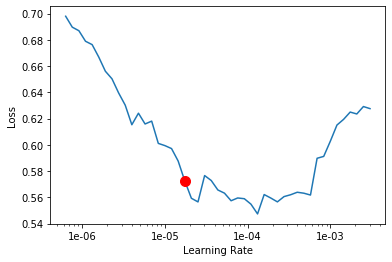

In [43]:
learner.recorder.plot(skip_end=7,suggestion=True)

In [0]:
# result for roberta
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.170503,0.170519,0.932992,09:26


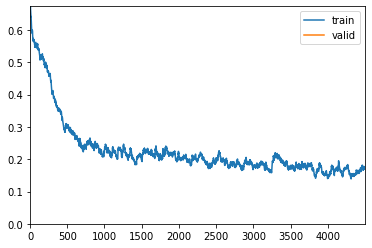

In [44]:
# result for Distilbert
learner.fit_one_cycle(1,max_lr=1e-05,moms=(0.8,0.7))

In [65]:
learner.show_results(rows=5)

text,target,prediction
"[CLS] i put my o ##cd to efficient use in researching the best organic cat food at the best price and this is what i found , and with which i am utterly delighted , but for one thing ( there ' s always a thing ) - - when i signed up for this auto - ship service it stated that i would be able to change the frequency",1,1
"[CLS] i ' ve ordered this coffee several times & it has been excellent every time . it ' s not over - roasted / burnt tasting & the flavor is very complex . the beans are oil ##y , black & i found no quakers ( under ##dev ##elo ##ped coffee beans that make coffee taste awful - they stick out because they do not roast / dark ##en",1,1
"[CLS] my 7 month old loves real food and the new organic foods on the market have been a god ' s send . i bought a box of the sweet ginger chicken w / bananas & coconut based on the reviews and the overall appeal of the name . we are now feeding them to our dog , which is appropriate because it looks , smells and tastes like",0,1
"[CLS] keep your receipt . the product is nasty . . . the product is guaranteed . . . but the process to get a ref ##und is one ##rous ( in my opinion ) . < br / > < br / > "" i am sorry that you were not satisfied with our mayo . please send a proof of purchase , a note with the ex ##piration",0,0
"[CLS] we ' ve gone through all of the flavors now three times . both cats chow ##ed down quite happily on the food . the boy got quite vocal and insistent the next few days about how much he wanted more of the wet food . far , far more vocal than he got after getting the 9 lives canned food before . judging from that it seems to",1,1


In [71]:
interp = learner.interpret(ds_type = DatasetType.Valid)
#txt_ci = TextClassificationInterpretation.from_learner(learner)

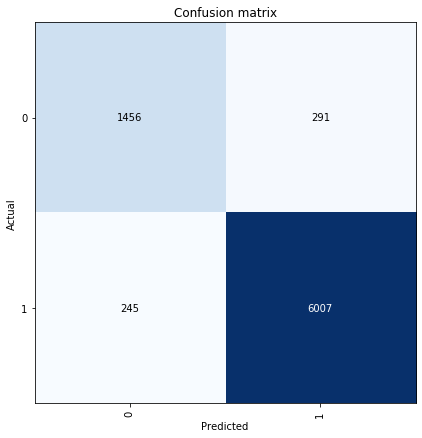

In [72]:
interp.plot_confusion_matrix(normalize=False,figsize=(6,6))

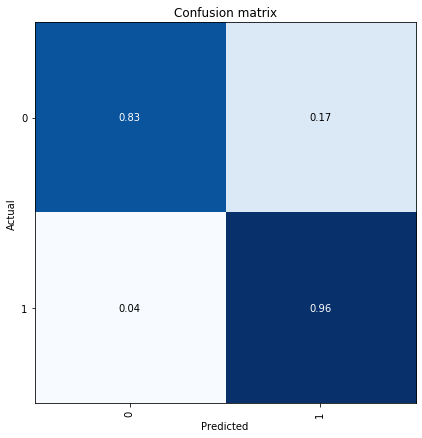

In [73]:
interp.plot_confusion_matrix(normalize=True,figsize=(6,6))

In [86]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

test_preds = get_preds_as_nparray(DatasetType.Test)

RuntimeError: ignored

In [78]:
test['label'].value_counts()

1    15348
0     4660
Name: label, dtype: int64

In [84]:
learner.get_preds(databunch.test_dl)

RuntimeError: ignored

In [81]:
databunch.test_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7fdf54c73d68>, device=device(type='cuda', index=0), tfms=[], collate_fn=functools.partial(<function pad_collate at 0x7fdf664c4d90>, pad_idx=1, pad_first=False, backwards=False))

### Reference
https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta